In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [3]:
flight_data = sns.load_dataset('flights')
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
flight_data.shape

(144, 3)

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

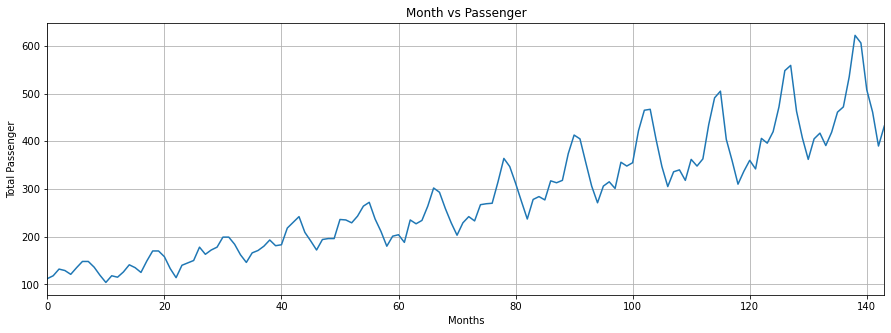

In [7]:
plt.title("Month vs Passenger")
plt.ylabel("Total Passenger")
plt.xlabel("Months")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])

In [8]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [9]:
# first preprocessing
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [10]:
test_data_size = 12

train_data = all_data[ : -test_data_size]
test_data = all_data[-test_data_size : ]

print("len(train_data) : {}".format(len(train_data)))
print("len(test_data) : {}".format(len(test_data)))

len(train_data) : 132
len(test_data) : 12


In [11]:
# second preprocessing
# min max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

In [14]:
print("train_data_normalized : \n{}".format(train_data_normalized[:5]))

train_data_normalized : 
[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]


In [15]:
print("train_data_normalized.shape : {}".format(train_data_normalized.shape))

train_data_normalized.shape : (132, 1)


In [16]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

print("train_data_normalized.shape : {}".format(train_data_normalized.shape))

train_data_normalized.shape : torch.Size([132])


In [17]:
train_window = 12

In [18]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    
    for i in range(L-tw):
        # 0 ~ 11
        train_seq = input_data[i:i+tw]
        # 12
        train_label = input_data[i+tw : i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [19]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [20]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [24]:
# input size : the number of features in the input
# hidden_layer_size : the number of hidden layers
# output_size : the number of items in the output
class LSTM_VER1(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size = 100, output_size = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # contain previous hidden state, previous cell state
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), 
                            torch.zeros(1,1, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) , 1, -1), self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return predictions[-1]

In [25]:
model = LSTM_VER1()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
print(model)

LSTM_VER1(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [28]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        
        model.hidden_cell = (torch.zeros(1,1, model.hidden_layer_size),
                            torch.zeros(1,1, model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00653846
epoch:  26 loss: 0.00065534
epoch:  51 loss: 0.02082437
epoch:  76 loss: 0.00346774
epoch: 101 loss: 0.00000033
epoch: 126 loss: 0.00012658
epoch: 149 loss: 0.0022290719


In [29]:
# prediction
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [30]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [31]:
test_inputs[fut_pred:]

[0.3587973117828369,
 0.31353411078453064,
 0.28202807903289795,
 0.5083266496658325,
 0.6053493022918701,
 0.5169903039932251,
 0.731021523475647,
 0.7601138353347778,
 0.46170157194137573,
 0.6556438207626343,
 0.7387317419052124,
 0.968629777431488]

In [34]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
print(actual_predictions)

[[413.12638843]
 [402.8290102 ]
 [395.66138798]
 [447.1443128 ]
 [469.21696627]
 [449.11529416]
 [497.80739659]
 [504.42589754]
 [436.53710762]
 [480.65896922]
 [499.56147128]
 [551.86327437]]


In [35]:
x = np.arange(132,144,1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


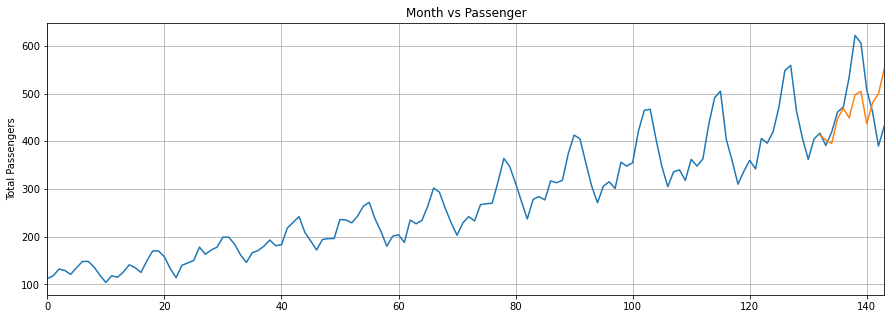

In [36]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

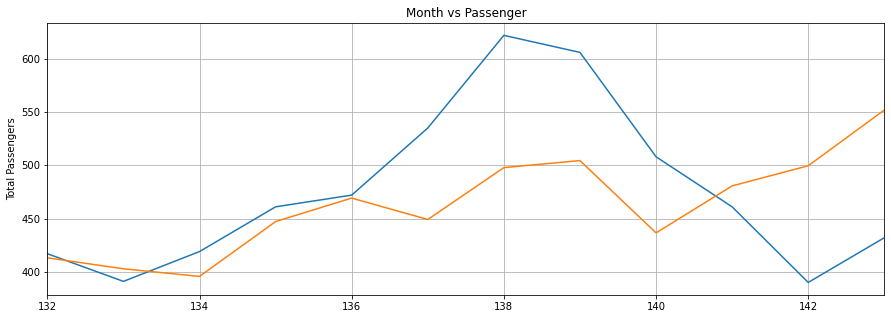

In [37]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()